# Protein-ligand interacions for 1NCR using PLIP

In [32]:
from plip.structure.preparation import PDBComplex
import numpy as np
import os

import pandas as pd
from io import StringIO, BytesIO

## Calculate interactions

In [2]:
my_mol = PDBComplex()

# Load the PDB file into PLIP class
my_mol.load_pdb('../data/pdbs/1ncr.pdb')

# Shows name of structure and ligand binding sites
print(my_mol) 

# Unique binding site identifier (HetID:Chain:Position)
my_bsid = 'W11:A:7001' 
my_mol.analyze()
my_interactions = my_mol.interaction_sets[my_bsid] # Contains all interaction data

Protein structure 1ncr with ligands:
ZN:A:6000
W11:A:7001
MYR:D:4000


### Analyze molecular system 

In [3]:
pdb_string = my_mol.corrected_pdb

In [4]:
from rdkit import Chem

mol_system = Chem.rdmolfiles.MolFromPDBBlock(pdb_string)
mol_system.GetNumAtoms()

6717

In [6]:
type(mol_system)

rdkit.Chem.rdchem.Mol

In [11]:
import nglview as nv

view = nv.show_rdkit(mol_system)
view 

NGLWidget()

In [12]:
# import molsysmt as msm

# molecular_system = msm.convert(pdb_string, to_form='molsysmt.MolSys')
# msm.info(molecular_system)

form,n_atoms,n_groups,n_components,n_chains,n_molecules,n_entities,n_waters,n_ions,n_small_molecules,n_peptides,n_proteins,n_frames
molsysmt.MolSys,6717,1145,344,10,344,7,338,1,2,1,2,1


In [ ]:
# view = msm.view(molecular_system, standardize=False)
# view

### Anlalyze a ligand

In [5]:
ligand_1 = my_mol.ligands[1]
ligand_1._fields

('mol',
 'hetid',
 'chain',
 'position',
 'water',
 'members',
 'longname',
 'type',
 'atomorder',
 'can_to_pdb')

In [7]:
":".join([ligand_1.hetid, ligand_1.chain, str(ligand_1.position)])

'W11:A:7001'

In [8]:
# print(ligand_1.mol)
# print(ligand_1.water)
print(ligand_1.mol)
print(ligand_1.position)

o1nc(C)cc1CCCOc1c(C)cc(cc1C)c1noc(n1)C(F)(F)F	W11:A:7001

7001


In [9]:
type(ligand_1.mol)

openbabel.pybel.Molecule

#### Get smiles from the molecule and transform to rdkit

In [10]:
open_babel_mol = ligand_1.mol
smiles = open_babel_mol.write("smi")
smiles = smiles.split()[0]
print(smiles)

o1nc(C)cc1CCCOc1c(C)cc(cc1C)c1noc(n1)C(F)(F)F


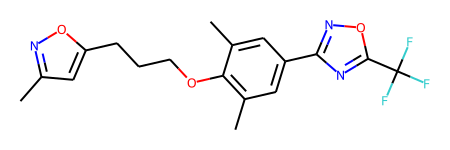

In [11]:
mol = Chem.MolFromSmiles(smiles)
mol

### Get 3D coordinates of the molecule
Get coordinates by converting molecule to mol2 format and then try with sdf format.

RDKit WARNING: [23:38:30] W11:A:7001: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
[23:38:30] W11:A:7001: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


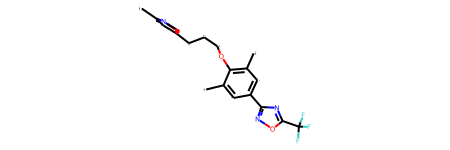

In [18]:
mol2_str = open_babel_mol.write("mol2")
rd_mol = Chem.MolFromMol2Block(mol2_str)
rd_mol

In [19]:
rd_mol.GetNumConformers()

1

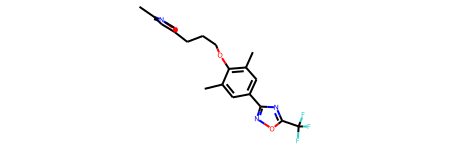

In [35]:
sdf_str = open_babel_mol.write("sdf")
sio = StringIO(sdf_str)
bio = BytesIO(sio.read().encode('utf8'))
mol = [mol for mol in Chem.ForwardSDMolSupplier(bio)]
mol = mol[0]
mol

In [14]:
pdbs_path = '../data/pdbs/'
pdbs = ["1ncr", "2hz1", "2hzi"]
pdbs = [p_id + ".pdb" for p_id in pdbs]

In [15]:
# Check type of each ligand in each file

lig_names = []
lig_types = []
atom_order = []
n_atoms = []
members = []

for file in pdbs:
    file_name = os.path.join(pdbs_path, file)
    mol_system = PDBComplex()
    mol_system.load_pdb(file_name)
    mol_system.analyze()
    for lig in mol_system.ligands:
        lig_types.append(lig.type)
        lig_names.append(lig.longname)
        atom_order.append(lig.atomorder)
        n_atoms.append(len(lig.atomorder))
        members.append(lig.members)

protein = {
    "ligand_names": lig_names,
    "ligand_types": lig_types,
    "n_atoms": n_atoms
}        

df = pd.DataFrame().from_dict(protein)
df

,ligand_names,ligand_types,n_atoms
0,ZN,ION,1
1,W11,SMALLMOLECULE,27
2,MYR,SMALLMOLECULE,15
3,CD,ION,1
4,CD,ION,1
5,SO3,SMALLMOLECULE,4
6,HEM,SMALLMOLECULE,43
7,SO2,SMALLMOLECULE,3
8,SO2,SMALLMOLECULE,3
9,JIN,SMALLMOLECULE,29


### Get all interactions for each ligand

In [13]:
my_mol.interaction_sets

{'ZN:A:6000': <plip.structure.preparation.PLInteraction at 0x7fe1ca7b62d0>,
 'W11:A:7001': <plip.structure.preparation.PLInteraction at 0x7fe1cc8f26d0>,
 'MYR:D:4000': <plip.structure.preparation.PLInteraction at 0x7fe1cb85ca50>}

In [46]:
# List with all interactions
interactions = my_interactions.all_itypes
print(f"Number of interactions: {len(interactions)}\n")

for interaction in interactions:
    # Interactions are named tuples.
    interaction_name = type(interaction).__name__
    print(interaction_name)

Number of interactions: 11

pistack
hydroph_interaction
hydroph_interaction
hydroph_interaction
hydroph_interaction
hydroph_interaction
hydroph_interaction
hydroph_interaction
hydroph_interaction
halogenbond
waterbridge


### Analyzing pistack interactions

In [48]:
pistack = interactions[0]

In [49]:
pistack._fields #pistack is a named tuple

('proteinring',
 'ligandring',
 'distance',
 'angle',
 'offset',
 'type',
 'restype',
 'resnr',
 'reschain',
 'restype_l',
 'resnr_l',
 'reschain_l')

In [79]:
ligand_ring_center = pistack.ligandring.center
ligand_normal_vector = pistack.ligandring.normal
print(f"Ligand ring; Center: {ligand_ring_center}, normal: {ligand_normal_vector}")

protein_ring_center = pistack.proteinring.center
protein_normal_vector = pistack.proteinring.normal
print(f"Protein ring; Center: {protein_ring_center}, normal: {protein_normal_vector}")

print(f"Distance between the rings is {pistack.distance}\n")

# Calculate distance
distance = np.linalg.norm(np.array(ligand_ring_center) - np.array(protein_ring_center))
print(distance == pistack.distance)

Ligand ring; Center: [38.029199999999996, 4.3594, 123.7382], normal: [ 0.55553186  0.81988479 -0.13846765]
Protein ring; Center: [34.878166666666665, 4.118666666666667, 120.25733333333334], normal: [0.63124087 0.22880385 0.74106933]
Distance between the rings is 4.7014249283240375

True


### Hydrophobic interactions

In [51]:
hydrophobic = interactions[1]
# bs is the binding site
hydrophobic._fields

('bsatom',
 'bsatom_orig_idx',
 'ligatom',
 'ligatom_orig_idx',
 'distance',
 'restype',
 'resnr',
 'reschain',
 'restype_l',
 'resnr_l',
 'reschain_l')

In [67]:
type(hydrophobic.ligatom.coords)

tuple

In [76]:
# Coordinates of atoms in each hydrophobic interaction
for i, hyd in enumerate(interactions[1 : -2]):
    # Calcualate the distance between ligand and bs atoms
    lig_coords = np.array(hyd.ligatom.coords)
    bs_coords = np.array(hyd.bsatom.coords)
    distance = np.linalg.norm(lig_coords - bs_coords)
    
    print(f"Hydrophobic interaction {i}")
    print(f"Coords of ligand atom are {lig_coords}")
    print(f"Coords of binding site are {bs_coords}\n")
    # print(f"Distance between atoms: {hyd.distance}")
    print(distance == hyd.distance)
    print("---------------------------------------------------")

Hydrophobic interaction 0
Coords of ligand atom are [ 42.868  -0.745 122.712]
Coords of binding site are [ 43.561  -1.507 126.451]

True
---------------------------------------------------
Hydrophobic interaction 1
Coords of ligand atom are [ 37.699   4.393 122.609]
Coords of binding site are [ 39.77    7.394 123.143]

True
---------------------------------------------------
Hydrophobic interaction 2
Coords of ligand atom are [ 43.755  -1.836 122.327]
Coords of binding site are [ 43.468  -4.771 124.599]

True
---------------------------------------------------
Hydrophobic interaction 3
Coords of ligand atom are [ 41.37   -1.11  122.681]
Coords of binding site are [ 42.136  -4.369 124.694]

True
---------------------------------------------------
Hydrophobic interaction 4
Coords of ligand atom are [ 41.37   -1.11  122.681]
Coords of binding site are [ 39.143  -0.55  120.239]

True
---------------------------------------------------
Hydrophobic interaction 5
Coords of ligand atom are [ 3

## Protein-ligand interacions for 2HZ1 using PLIP

In [81]:
mol_system = PDBComplex()

# Load the PDB file into PLIP class
mol_system.load_pdb('./Data/pdbs/2hz1.pdb')

# Shows name of structure and ligand binding sites
print(mol_system) 

Protein structure 2hz1 with ligands:
CD:A:201
CD:A:202
SO3:A:204
HEM:A:125
SO2:A:203
SO2:A:205


In [82]:
mol_system.analyze()
mol_system_interactions = mol_system.interaction_sets["HEM:A:125"] # Contains all interaction data

In [83]:
# List with all interactions
interactions = mol_system_interactions.all_itypes
print(f"Number of interactions: {len(interactions)}\n")

for interaction in interactions:
    # Interactions are named tuples.
    interaction_name = type(interaction).__name__
    print(interaction_name)

Number of interactions: 21

saltbridge
saltbridge
hbond
hydroph_interaction
hydroph_interaction
hydroph_interaction
hydroph_interaction
hydroph_interaction
hydroph_interaction
hydroph_interaction
hydroph_interaction
hydroph_interaction
hydroph_interaction
waterbridge
waterbridge
metal_complex
metal_complex
metal_complex
metal_complex
metal_complex
metal_complex


### Salt Bridges

In [84]:
salt_bridge = interactions[0]
salt_bridge._fields

('positive',
 'negative',
 'distance',
 'protispos',
 'resnr',
 'restype',
 'reschain',
 'resnr_l',
 'restype_l',
 'reschain_l')

In [88]:
salt_bridge.positive

pcharge(atoms=[<openbabel.pybel.Atom object at 0x7fe1ca81c490>], atoms_orig_idx=[331], type='positive', center=[-0.724, 0.962, 4.197], restype='LYS', resnr=42, reschain='A')

In [98]:
atoms = salt_bridge.negative.atoms
center = salt_bridge.negative.center

coords_array = np.array([atoms[0].coords, atoms[1].coords])

centroid = np.mean(coords_array, axis=0)

print(centroid)
print(center)

[2.279  2.6625 3.2525]
[2.279, 2.6624999999999996, 3.2525]


In [90]:
# The positive charge is in the protein
salt_bridge.protispos

True

### Hydrogen bonds

In [99]:
hbond = interactions[2]
hbond._fields

('a',
 'a_orig_idx',
 'd',
 'd_orig_idx',
 'h',
 'distance_ah',
 'distance_ad',
 'angle',
 'type',
 'protisdon',
 'resnr',
 'restype',
 'reschain',
 'resnr_l',
 'restype_l',
 'reschain_l',
 'sidechain',
 'atype',
 'dtype')

In [100]:
# The donor atom is in the protein. Thus the acceptor is in the ligand
hbond.protisdon

True

In [106]:
# acceptor
acceptor = hbond.a
print(acceptor)

Atom: 8 (2.33 3.57 2.63)
